# Taufactor Overview

TauFactor is an open-source, GPU accelerated microstructural analysis tool for extracting metrics from voxel based data, including volume fractions, interfacial areas and effective transport properties.

## Tortuosity solvers

The tortuosity factor $\tau$ is a morphological parameter that defines the reduction in transport arising from constrictions and tortuos pathways.

The main output of the solve function is `tau` and `D_eff`. `tau` is the tortuoisty factor, a measure of the reduction in diffusive transport caused by convolution in the geometry of the material. `D_eff` is the effective diffusivity resulting from the tortuous nature of the material. The relationship between these values is given by:

$D_{eff}=D\frac{\epsilon}{\tau}$

For more see [Cooper _et al._](https://doi.org/10.1016/j.softx.2016.09.002)

In [1]:
import taufactor as tau
import tifffile

# Load segmented image, in this case with
# labels {"pore":0, "NMC":1, "CBD":2}
img = tifffile.imread('electrode.tif')
s = tau.Solver(img==0)
s.solve()

print(f"tau = {s.tau[0]:.4f}, D_eff = {s.D_eff[0]:.4f}*D_0")

converged to: [2.7358541] after: 900 iterations in: 13.3867s (0.0149 s/iter)
GPU-RAM currently 329.02 MB (max allocated 458.81 MB; 465.57 MB reserved)
tau = 2.7359, D_eff = 0.1312*D_0


The iteration limit, convergence criteria and verbosity of the solver can be adjusted. Setting `verbose='per_iter'` logs the output of the solver every 100 steps whilst solving. The option `verbose='plot` plots the relative flux convergence every 100*`plot_interval` steps. `verbose='None` disables all written output. The `conv_crit` controls the value at which convergence is met.

Iter: 1400, conv error: 8.760E-04, tau: 2.73602 (batch element 0)


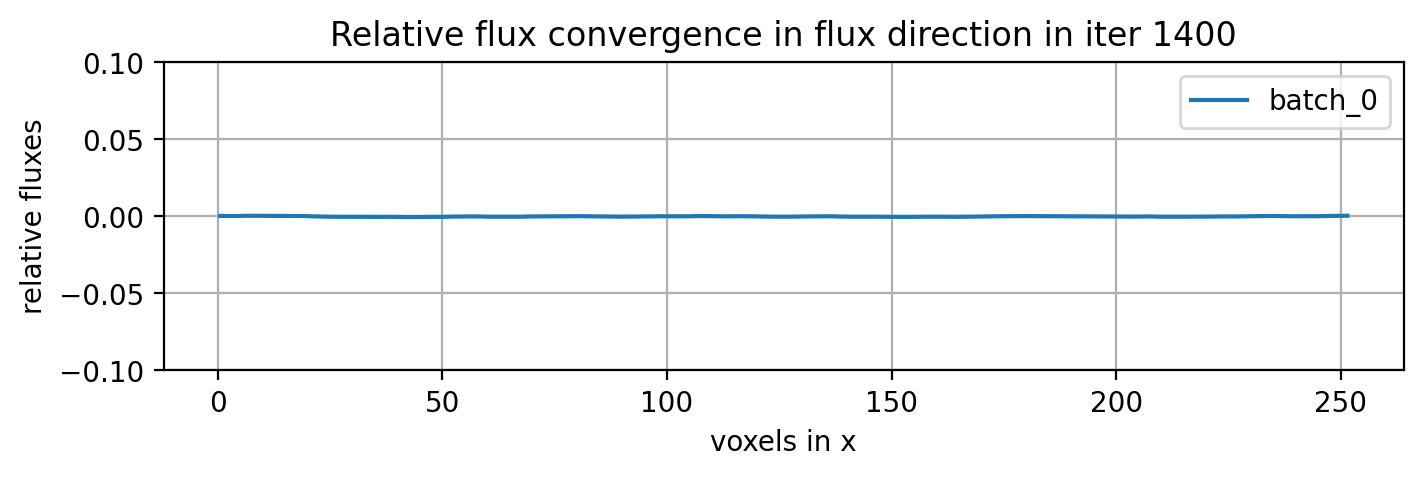

converged to: [2.7360182] after: 1400 iterations in: 22.0495s (0.0157 s/iter)
GPU-RAM currently 328.78 MB (max allocated 458.81 MB; 599.79 MB reserved)


array([2.7360182], dtype=float32)

In [2]:
s = tau.Solver(img==0)
s.solve(verbose='plot', plot_interval=1, conv_crit=1e-3)

By default, the direction of transport is the first index of the loaded image. If a different direction is required, the image must be permuted before solving. To visualise this and give guidance, the utility function `flux_direction` can be used.

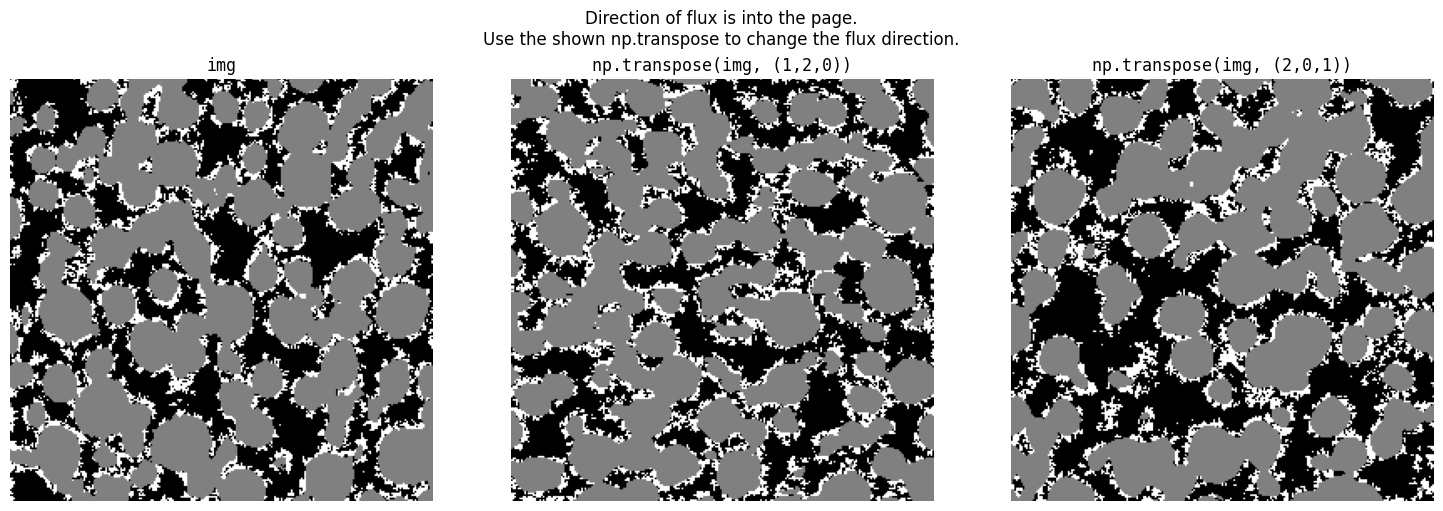

In [3]:
from taufactor.utils import flux_direction
figure = flux_direction(img)

Therefore, to solve the simulation in the y direction we can run

In [4]:
import numpy as np

s = tau.Solver(np.transpose(img, (1,2,0))==0)
s.solve(verbose=None)

print(f"Tau in y-direction is {s.tau[0]:.4f}")

Tau in y-direction is 2.7649


## Other Solvers

### Periodic solver

The periodic solver applies periodic boundary conditions instead of mirror boundaries.

```python
s = tau.PeriodicSolver(img==0)
s.solve()
```

### Anisotropic solver

The anisotropic solver accounts for non-cubic voxels such as commonly encountered in FIB-SEM stacks (different spacing dz in cutting direction). If dz is twice as large as the pixel resolution dx=dy, set the `spacing=(1,1,2)`.

```python
s = tau.AnisotropicSolver(img==0, spacing=(1,1,2))
s.solve()
```

### Multi-phase solver

The multi-phase solver allows for more than 2 conductive phases per image. The conductivity of each phase is given as an input to the solver along with the phase label

```python
# assign conductivity values, where key is segmented label in 'img'
# and value is conductivity
cond = {1:0.32, 2:0.44}

# create a multiphase solver object and set an iteration limit
s = tau.MultiPhaseSolver(img, cond=cond, iter_limit=1000)
# call solve function
s.solve()
```

## Metrics

Metrics can be calculated using the metrics module

```python
from taufactor.metrics import *
```

### Volume fraction

Volume fraction is calculated for each phase in a segmented image:

```python
from taufactor.metrics import volume_fraction

# calculate the volume fraction
vf = volume_fraction(img)

# consider a three phase image with pore, particle and binder
# where 0, 1, 2 correspond to pore, particle and binder respectively
# calculate the volume fraction
vf = volume_fraction(img, phases={'pore':0, 'particle':1, 'binder':2})
```

### Specific surface area

Per default, the specific surface area is calculated for each phase in a segmented image.
Alternatively, the phases can be specified as phases={'phase1': 0, ...}.
The method to compute surface area can be chosen as
'face_counting', 'marching_cubes' or 'gradient'. A detailed comparison of these methods can be found in [Daubner _et al._](https://doi.org/10.1149/1945-7111/ad9a07).
While face_counting is the fastest, the gradient method yields more accurate results for curved geometries.

```python
from taufactor.metrics import specific_surface_area
# calculate the surface area of all phases in an image
sa = specific_surface_area(img)

# Surface area of a particular phase on anisotropic voxel grid (e.g. FIB-SEM data)
sa = specific_surface_area(img, spacing=(1,1,3), phases={'pore': 0})

# consider a three phase image with pore, particle and binder
# where 0, 1, 2 correspond to pore, particle and binder respectively
# Use voxel face counting for fastest computation
labels={'pore':0, 'particle':1, 'binder':2}
sa = surface_area(img, phases=labels, method='face_counting')
```

### Triple phase boundary

Triple phase boundary is calculated on a segmented image with exactky three phases. The value returned is the fraction of triple phase edges with respect to the total number of edges

```python
from taufactor.metrics import triple_phase_boundary
# calculate the triple phase boundareies
tpb = triple_phase_boundary(img)
```